<a href="#Import"> 1. Import Dependencies </a><br>
<a href="#Validate"> 2. Validate Data </a><br>
<a href="#Prune"> 3. Prune Data</a><br>
<a href="#ML"> 4. Machine Learning </a>

<hr>

## 1. Import Dependencies <a id='Import'></a>

In [139]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

from mongoHandler import mongoHandler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import shap


In [140]:
#mongoHandler = mongoHandler()
#mongoHandler.pullMongoDB("pastdata.csv")

## 2. Validate Data <a id=Validate></a>

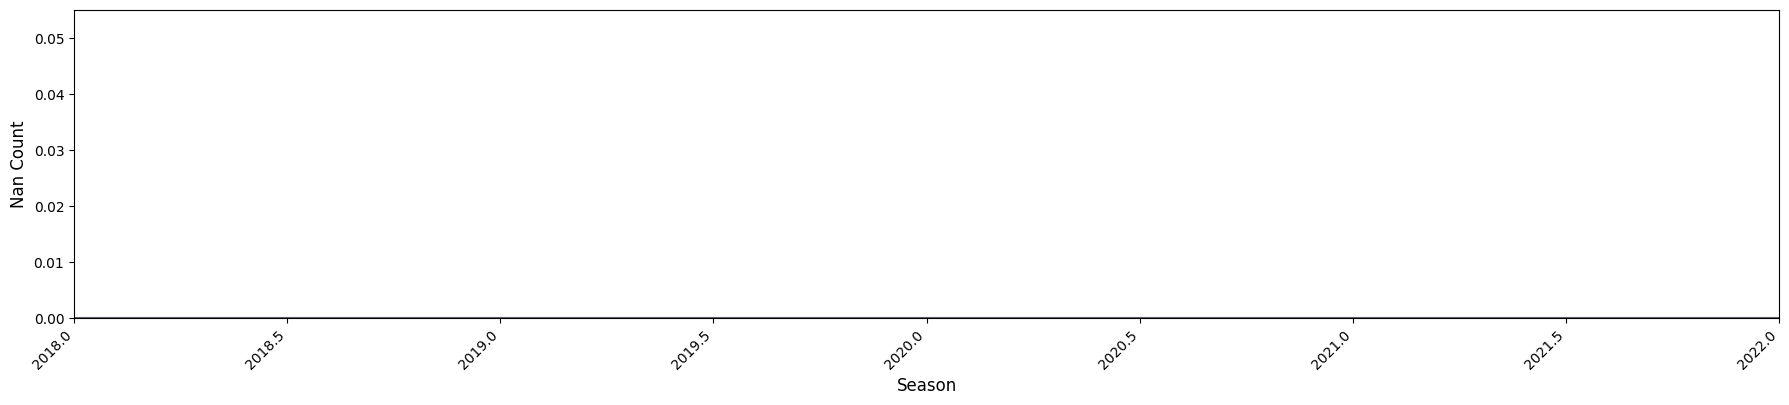

In [141]:
# This is optional as our data does not have any null values, but may be useful for other data sets
df = pd.read_csv("pastdata.csv")
prediction = pd.read_csv('2023data.csv')
df_detail_nan = []

for season in df['season'].unique():
    df_nan = df[df['season'] == season]
    series_nan = df_nan.isnull().sum()
    df_nan = series_nan.to_frame(name="Nan_Count")
    df_nan = df_nan.rename_axis('Col_Name').reset_index()
    df_nan['season'] = season
    df_detail_nan.append(df_nan)

df_detail_nan = pd.concat(df_detail_nan, ignore_index=True)

df_per_season_nan = df_detail_nan[['season','Nan_Count']].groupby("season").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['season'], ascending=True)

fig = plt.figure(figsize = (22, 4))
sns.lineplot(data=df_per_season_nan, x="season", y="Nan_Count", sort=True)
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Season', fontsize=12)
plt.margins(x=0)
plt.show()

## 3. Prune Data <a id="Prune">

In [142]:
# These stats are either duplicates or not useful for our analysis
STATS_TO_DROP = [
    'players_used', 'games', 'games_starts', 'minutes', 'minutes_90s', 'goals', 'assists',
    'goals_assists', 'goals_pens', 'pens_made', 'pens_att', 'cards_yellow', 
    'cards_red','xg', 'npxg','xg_assist', 'npxg_xg_assist', 'gk_games', 
    'gk_games_starts', 'gk_minutes','gk_goals_against', 'gk_saves', 'gk_wins', 
    'gk_ties', 'gk_losses','gk_clean_sheets', 'gk_pens_att', 'gk_pens_allowed', 
    'gk_pens_saved', 'gk_pens_missed', 'gk_psxg_net', 'gk_passes_completed_launched',
    'gk_passes_launched', 'gk_crosses_stopped', 'gk_def_actions_outside_pen_area',
    'shots', 'shots_on_target', 'sca', 'gca'
]

# These stats are too representative of the amount of games played, leading to skewed results.
# Thus we convert them to per 90 stats.
STATS_TO_PER90 = [
    'progressive_carries', 'progressive_passes', 'gk_free_kick_goals_against', 
    'gk_corner_kick_goals_against', 'gk_own_goals_against', 'gk_psxg', 'gk_passes', 
    'gk_passes_throws', 'gk_goal_kicks', 'gk_crosses', 'xg_net', 'npxg_net', 'passes_completed', 
    'passes_total_distance', 'passes_progressive_distance', 'passes', 'passes_completed_short',
    'passes_short', 'passes_completed_medium', 'passes_medium', 'passes_completed_long',
    'passes_long', 'pass_xa', 'xg_assist_net', 'assisted_shots', 'passes_into_final_third',
    'passes_into_penalty_area', 'crosses_into_penalty_area', 'passes_live', 'passes_dead',
    'passes_free_kicks', 'through_balls', 'passes_switches', 'crosses', 'throw_ins',
    'corner_kicks', 'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight',
    'passes_offsides', 'passes_blocked', 'sca_passes_live', 'sca_passes_dead',
    'sca_take_ons', 'sca_shots', 'sca_fouled', 'sca_defense', 'gca_passes_live',
    'gca_passes_dead', 'gca_take_ons', 'gca_shots', 'gca_fouled', 'gca_defense',
    'tackles', 'tackles_won', 'tackles_def_3rd', 'tackles_mid_3rd', 'tackles_att_3rd',
    'challenge_tackles', 'challenges', 'challenges_lost', 'blocks', 'blocked_shots',
    'blocked_passes', 'interceptions', 'tackles_interceptions', 'clearances', 'errors',
    'touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
    'touches_att_pen_area', 'touches_live_ball', 'take_ons', 'take_ons_won',
    'take_ons_tackled', 'carries', 'carries_distance', 'carries_progressive_distance',
    'carries_into_final_third', 'carries_into_penalty_area', 'miscontrols', 'dispossessed',
    'passes_received', 'progressive_passes_received', 'cards_yellow_red', 'fouls', 'fouled',
    'offsides', 'pens_won', 'pens_conceded', 'own_goals', 'ball_recoveries', 'aerials_won',
    'aerials_lost'
]



In [143]:
df[STATS_TO_PER90] = df[STATS_TO_PER90].div(df['minutes_90s'], axis=0)
prediction[STATS_TO_PER90] = prediction[STATS_TO_PER90].div(prediction['minutes_90s'], axis=0)
df.drop(columns=STATS_TO_DROP, inplace=True)
prediction.drop(columns=STATS_TO_DROP, inplace=True)

In [144]:
df = df.rename(columns={col: col + '_per90' for col in STATS_TO_PER90})
prediction = prediction.rename(columns={col: col + '_per90' for col in STATS_TO_PER90})

## 4. Machine Learning <a id="ML"></a>

In [145]:
target = df['position']
features = df.drop(['position','team'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
#model = RandomForestClassifier()
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Test Prediction: {', '.join(map(str, y_pred))}")

Test Prediction: 14.59, 7.33, 7.74, 9.33, 12.52, 15.76, 13.76, 9.51, 8.52, 6.52, 6.29, 7.11, 16.56, 10.04, 13.67, 15.64, 16.56, 16.64, 9.48, 6.7, 16.76, 14.72, 10.53, 10.18, 14.21, 16.36, 7.61, 9.04, 5.86, 8.3, 15.64, 16.18


In [146]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f"MAE: {MAE.round(4)}")
print(f"MSE: {MSE.round(4)}")

MAE: 2.5231
MSE: 10.2288


In [147]:
prediction = prediction.drop(['team'],axis=1)
y_pred2 = model.predict(prediction)
print(f"2023 Prediction : {', '.join(map(str, y_pred2))}")

2023 Prediction : 14.06, 14.24, 10.58, 6.42, 7.66, 15.48, 10.97, 13.1, 16.6, 6.89, 14.26, 14.56, 7.18, 12.24, 12.59, 6.91, 15.24, 4.4, 13.12, 8.11, 6.13, 8.95, 8.25, 16.76, 11.41, 13.32, 3.93, 13.88, 14.59, 12.05, 11.75, 16.64


In [148]:
prediction

,avg_age,possession,progressive_carries_per90,progressive_passes_per90,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg_per90,...,offsides_per90,pens_won_per90,pens_conceded_per90,own_goals_per90,ball_recoveries_per90,aerials_won_per90,aerials_lost_per90,aerials_won_pct,topGoals,season
0,27.2,53.2,13.333333,39.000000,1.83,1.50,3.33,1.67,3.17,1.39,...,3.000000,0.166667,0.333333,0.000000,48.833333,9.166667,14.000000,39.6,4,2023
1,29.5,56.5,18.500000,47.666667,0.67,0.50,1.17,0.67,1.17,1.59,...,3.333333,0.166667,0.166667,0.000000,51.500000,12.500000,13.500000,48.1,1,2023
2,27.2,64.8,27.833333,59.666667,2.00,1.67,3.67,2.00,3.67,1.65,...,1.333333,0.000000,0.166667,0.000000,52.333333,11.500000,11.666667,49.6,5,2023
3,27.4,56.1,24.900000,54.100000,2.10,1.90,4.00,2.00,3.90,1.94,...,2.600000,0.000000,0.100000,0.000000,57.400000,10.500000,11.300000,48.2,4,2023
4,26.8,52.9,18.700000,45.500000,2.50,1.60,4.10,2.00,3.60,1.92,...,1.600000,0.400000,0.300000,0.000000,53.700000,11.500000,14.300000,44.6,6,2023
5,26.8,44.2,16.333333,50.000000,0.50,0.17,0.67,0.50,0.67,1.53,...,0.666667,0.166667,0.333333,0.000000,48.500000,7.000000,7.166667,49.4,2,2023
6,27.7,57.3,21.100000,51.200000,1.20,0.70,1.90,1.00,1.70,1.62,...,2.700000,0.100000,0.000000,0.000000,59.700000,11.600000,10.900000,51.6,3,2023
7,27.1,45.6,13.625000,29.875000,1.00,0.87,1.87,0.87,1.75,1.00,...,1.750000,0.250000,0.375000,0.000000,48.625000,14.250000,12.000000,54.3,2,2023
8,27.7,46.8,17.833333,32.333333,0.67,0.33,1.00,0.67,1.00,0.70,...,0.333333,0.000000,0.500000,0.166667,51.000000,14.500000,12.000000,54.7,2,2023
9,26.8,47.9,19.875000,37.500000,1.37,1.25,2.62,1.37,2.62,1.31,...,1.000000,0.000000,0.250000,0.000000,53.375000,8.500000,10.750000,44.2,4,2023


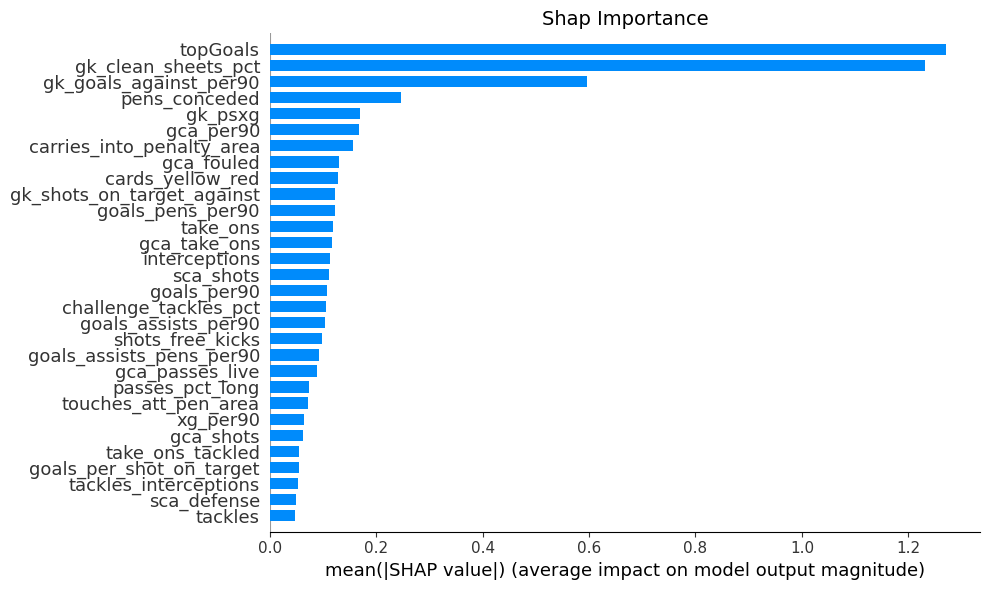

In [111]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features.columns.to_list(), 
                    show=False, max_display=30)

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance", fontsize=14, loc="center")   
plt.tight_layout()
plt.show()